In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import yfinance as yf
df = yf.download('005930.KS','2021-06-03','2022-06-03')
df.to_excel("samsung.xlsx")
df.to_csv("samsung.csv")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-03,81300.0,83000.0,81100.0,82800.0,78860.304688,29546007
2021-06-04,82700.0,82700.0,81500.0,82200.0,78288.835938,18112259
2021-06-07,82700.0,82800.0,81600.0,81900.0,78003.117188,16496197
2021-06-08,82300.0,82600.0,81800.0,81900.0,78003.117188,12781226
2021-06-09,81500.0,82000.0,81100.0,81100.0,77241.195312,14908823
...,...,...,...,...,...,...
2022-05-26,66300.0,67200.0,65500.0,65900.0,63956.925781,15970890
2022-05-27,66700.0,66900.0,66200.0,66500.0,64539.238281,11405555
2022-05-30,67500.0,67800.0,66900.0,67700.0,65703.851562,14255484


In [ ]:
df.shape

(245, 6)

In [ ]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

In [ ]:
dfx = df[['Open', 'High', 'Low', 'Close', 'Volume']]
dfx = MinMaxScaler(dfx)

dfy = dfx[['Close']]
dfx = dfx[['Open', 'High', 'Low', 'Volume']]

dfx

,Open,High,Low,Volume
Date,,,,
2021-06-03,0.890110,0.983146,0.948571,0.482221
2021-06-04,0.967033,0.966292,0.971429,0.295611
2021-06-07,0.967033,0.971910,0.977143,0.269235
2021-06-08,0.945055,0.960674,0.988571,0.208603
2021-06-09,0.901099,0.926966,0.948571,0.243327
...,...,...,...,...
2022-05-26,0.065934,0.095506,0.057143,0.260661
2022-05-27,0.087912,0.078652,0.097143,0.186150
2022-05-30,0.131868,0.129213,0.137143,0.232664


In [ ]:
dfx.describe()

,Open,High,Low,Volume
count,245.000000,245.000000,245.000000,245.000000
mean,0.498946,0.513231,0.519650,0.239820
std,0.265445,0.268757,0.272698,0.109234
min,0.000000,0.000000,0.000000,0.000000
25%,0.280220,0.286517,0.302857,0.187514
50%,0.505495,0.528090,0.531429,0.222054
75%,0.730769,0.752809,0.742857,0.274398
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
dfy.head()

,Close
Date,
2021-06-03,0.994475
2021-06-04,0.961326
2021-06-07,0.944751
2021-06-08,0.944751
2021-06-09,0.900552


In [ ]:
time_step = 10
step = 1

def create_dataset(X, y, time_step, step):
    Xs, ys = [], []

    for i in range(0, len(X) - time_step, step):
        v = X.iloc[i : (i + time_step)].values
        labels = y.iloc[i + time_step]

        Xs.append(v)
        ys.append(labels)

    return np.array(Xs), np.array(ys)

In [ ]:
X, y = create_dataset(dfx, dfy, time_step, step)

X.shape

(235, 10, 4)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((157, 10, 4), (78, 10, 4), (157, 1), (78, 1))

In [ ]:
from keras.models import Sequential

from keras.layers import Conv1D, Dense, LSTM
from keras.layers import MaxPooling1D, BatchNormalization, Dropout, Flatten

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(LSTM(16, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(n_outputs))

model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 64)            17664     
                                                                 
 dropout_16 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 10, 32)            12416     
                                                                 
 dropout_17 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_10 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_18 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 8)               

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=32,
                    validation_split=0.33, shuffle=True)

Epoch 1/250
4/4 [==============================] - 25s 424ms/step - loss: 0.4341 - mse: 0.4341 - val_loss: 0.3099 - val_mse: 0.3099
Epoch 2/250
4/4 [==============================] - 0s 33ms/step - loss: 0.2720 - mse: 0.2720 - val_loss: 0.1704 - val_mse: 0.1704
Epoch 3/250
4/4 [==============================] - 0s 36ms/step - loss: 0.1476 - mse: 0.1476 - val_loss: 0.0503 - val_mse: 0.0503
Epoch 4/250
4/4 [==============================] - 0s 30ms/step - loss: 0.0620 - mse: 0.0620 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 5/250
4/4 [==============================] - 0s 31ms/step - loss: 0.1053 - mse: 0.1053 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 6/250
4/4 [==============================] - 0s 34ms/step - loss: 0.0642 - mse: 0.0642 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 7/250
4/4 [==============================] - 0s 31ms/step - loss: 0.0505 - mse: 0.0505 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 8/250
4/4 [==============================] - 0s 34ms/step - loss: 0.0639 - mse: 0.

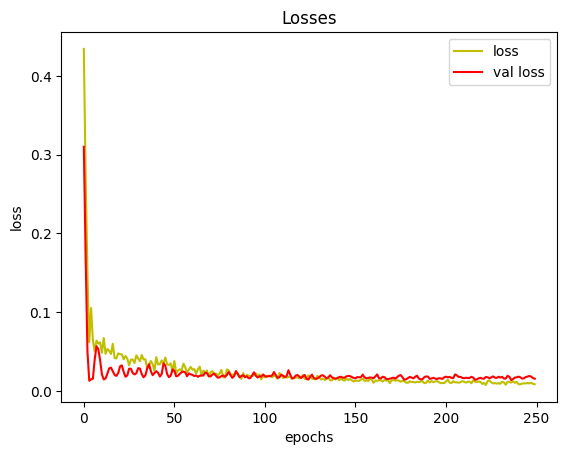

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)


3/3 [==============================] - 2s 10ms/step


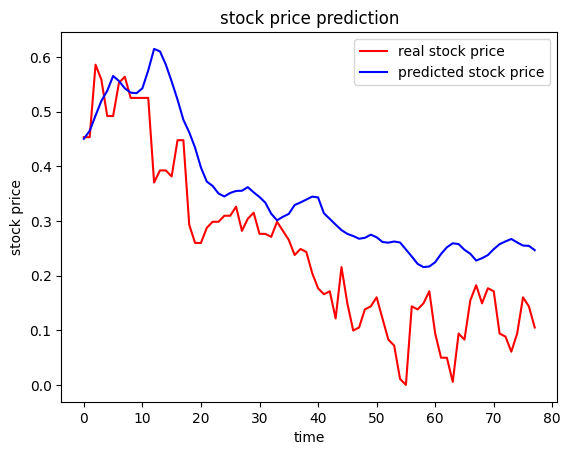

In [ ]:
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(n_outputs))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 9, 64)             576       
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 4, 64)             0         
 ng1D)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                8224      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8833 (34.50 KB)
Trainable params: 8833 (34.50 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=32,
                    validation_split=0.33, shuffle=True)

Epoch 1/250
4/4 [==============================] - 2s 95ms/step - loss: 0.3236 - mse: 0.3236 - val_loss: 0.1474 - val_mse: 0.1474
Epoch 2/250
4/4 [==============================] - 0s 25ms/step - loss: 0.0909 - mse: 0.0909 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 3/250
4/4 [==============================] - 0s 25ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 4/250
4/4 [==============================] - 0s 26ms/step - loss: 0.0409 - mse: 0.0409 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 5/250
4/4 [==============================] - 0s 20ms/step - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 6/250
4/4 [==============================] - 0s 24ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 7/250
4/4 [==============================] - 0s 24ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 8/250
4/4 [==============================] - 0s 18ms/step - loss: 0.0221 - mse: 0.02

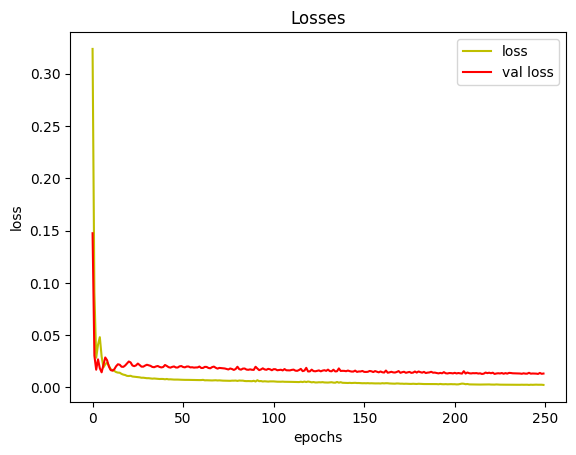

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)


3/3 [==============================] - 0s 3ms/step


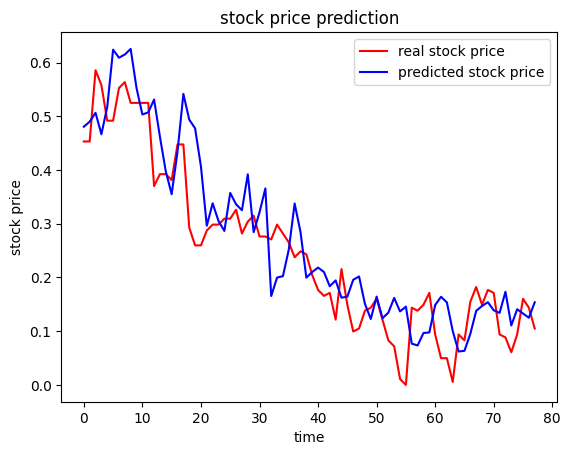

In [ ]:
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()